In [44]:
import json
import math
from collections import defaultdict
from dataclasses import dataclass

import matplotlib
import numpy as np

import seaborn as sns

# analyses_output_filename = 'output_apo_holo_2021-10-26T13:19:06.306504.json'
# domain_info_filename = 'output_domains_info2021-10-26T13:19:06.306504.json'
from matplotlib import pyplot as plt

analyses_output_filename = '/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/apo_holo_structure_stats/test/test_pipeline_output/paper_dataset/output_apo_holo_2022-04-27T17:02:30.109873.json'
domain_info_filename = '/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/apo_holo_structure_stats/test/test_pipeline_output/paper_dataset/output_domains_info_2022-04-27T17:02:30.109873.json'

import pandas as pd

from apo_holo_structure_stats.core.json_deserialize import tuple_it, unfold_tuple_to_columns, tuple_columns

with open(analyses_output_filename) as f:
    analyses_json = json.load(f)

analyses_output = defaultdict(list)

for obj in analyses_json:
    obj['args'] = tuple_it(obj['args'])  # json converted all my tuples to lists... won't work with hashing for joins..
    analyses_output[obj['level_tag']].append(obj)

analyses_dfs = {}
# convert analyses outputs to DataFrames
for k in analyses_output:
    analyses_dfs[k] = pd.DataFrame(analyses_output[k])

# analyses_output = pd.read_json(analyses_output_filename)
domain_info = pd.read_json(domain_info_filename)
domain_info = domain_info.applymap(tuple_it)


# with open(domain_info_filename) as f:
#     domain_info = json.load(f)

get apo-holo pairs
jinak nevim, co patri k sobe
treba z toho analyses_output,

In [45]:
# indices = analyses_output['analysis_name'] == 'GetRMSD'
# indices = indices & (pd.Series([len(args) for args in analyses_output['args']]) == 2)
#
# hah = analyses_output[indices]

Divide chains in multi-domain and single domain groups

In [46]:
a_h_pairs = analyses_dfs['chain2chain']['args'].drop_duplicates()
# unfold the tuple of chains into two columns
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['apo_chain','holo_chain'])
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['apo_pdb_code', 'apo_chain_id'], 'apo_chain')


pozor duplikáty 2bnu", "chain_id_apo": "B", "pdb_code_holo": "2bnq", "chain_id_holo": "E"
- protože už to dělá chains_for_uniprot  -> oba mají dva uniproty
- pak se vytvoří dva stejné páry (pro každý unp)
- a jde to do analýz (neměl by tam být nějaký filtr na unp? No, ne nutně, ale nevim, proč to má víc namapovaných UNP - jakože to je chimeric?)

In [47]:
@dataclass
class Chain:
    pdb_code: str
    chain_id: str

# domain_info = domain_info.rename(columns={'result': 'domain_count'})
full_domains = domain_info[domain_info['type'] == 'full_domain']
analyzed_domains = domain_info[domain_info['type'] == 'analyzed_domain']


full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
analyzed_domain_counts = analyzed_domains.groupby(by=['pdb_code', 'chain_id']).size()
print(full_domain_counts)
print('single domain proteins', full_domain_counts[full_domain_counts == 1].count())
print('multi domain proteins', full_domain_counts[full_domain_counts > 1].count())

pdb_code  chain_id
1a0s      R           1
1a0t      P           1
1a3l      L           2
1a3y      A           1
1a5v      A           1
                     ..
5eug      A           1
6rhn      A           1
6taa      A           2
7req      D           2
9rnt      A           1
Length: 874, dtype: int64
single domain proteins 523
multi domain proteins 351


In [48]:
# do single dám zatim i ty, co maj total domain víc
# ale do bakalarky to udelam i s porovnanim, kdyz maj jen 1 (kolik jich je - pouze 2 chainy, ktery maj vic total
# domains..)

domain_info['chain'] = list(zip(domain_info.pdb_code, domain_info.chain_id))


multi_domain_chains = analyzed_domain_counts[analyzed_domain_counts > 1]
single_domain_chains = analyzed_domain_counts[analyzed_domain_counts == 1]

print(single_domain_chains.count())
print(multi_domain_chains.count())

print(len(multi_domain_chains))
# print(domain_count)
print(len(single_domain_chains))

# label single, multi domain pairs
a_h_pairs = a_h_pairs.merge(analyzed_domain_counts.rename('domain_count'), left_on=['apo_pdb_code', 'apo_chain_id'],                                                                                            right_index=True)
#
# multi_domain_pairs = a_h_pairs.merge(multi_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                   'holo_chain']]
# single_domain_pairs = a_h_pairs.merge(single_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                                                                                                                    'holo_chain']]
# chci col a-h tuplů, a col single/multi

# todo
# describe pairs - count, min, max length (don't have that in saved metadata)
# filter two-domain arrangements (if of both apo and holo > 200 A^2)

522
352
352
522


Paper:
> 521 representative ligand-bound/
ligand-free pairs with lengths varying from 50 to 1392
residues was compiled. This results in 328 single-domain
proteins, 193 multiple-domain proteins, 487 individual
protein domains, and 311 two-domain arrangements.

Therefore as "individual domains" they mean only those from multi-domain proteins.

A-H Secondary structure identity in single/multi domain proteins (proteins myslej páry)
- join ss analysis with domain counts (decide what if # total domains different in pair or != 1)
histogram with bins for SS identity (2%)

In [49]:
from pathlib import Path

# sns.reset_orig()
sns.set_context('talk')
matplotlib.rcParams['figure.figsize'] = 8,6

plot_counter = 0
plot_path = Path('output_plots')
plot_path.mkdir(exist_ok=True)

def save_plot():
    global plot_counter
    plt.savefig(str(plot_path / f'paper_plot{plot_counter}.png'))
    plot_counter += 1


                 analysis_name                    args kwargs    result  \
235  CompareSecondaryStructure  ((2fjy, B), (1dqe, A))     {}  0.766423   
313  CompareSecondaryStructure  ((1w93, A), (1w96, A))     {}  0.797814   

       level_tag  apo_chain holo_chain apo_pdb_code apo_chain_id  \
235  chain2chain  (2fjy, B)  (1dqe, A)         2fjy            B   
313  chain2chain  (1w93, A)  (1w96, A)         1w93            A   

     domain_count   domain_label  
235             1  single domain  
313             4   multi domain  


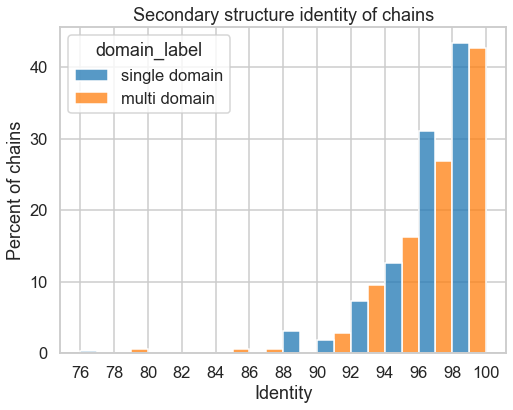

In [50]:
#jenze ted je zas to zabaleny...
df = analyses_dfs['chain2chain']
df = df[df.analysis_name == 'CompareSecondaryStructure']

df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'

print(df[df.result < 0.8])

def rounded_bins(a, binwidth):
    lower_bound = math.floor(np.min(a) / binwidth) * binwidth
    upper_bound = math.ceil(np.max(a) / binwidth) * binwidth

    return np.linspace(lower_bound, upper_bound, 1 + (int) ((upper_bound-lower_bound) / binwidth))

df['result_percent'] = df.result * 100
BINWIDTH = 2
# BINWIDTH = 0.02
hue_order = ['single domain', 'multi domain']
ax = sns.histplot(df, x='result_percent', stat='percent', common_norm=False, hue='domain_label',
             hue_order=hue_order, multiple='dodge', bins=rounded_bins(df['result_percent'], BINWIDTH))
             # hue_order=hue_order, multiple='dodge', binwidth=BINWIDTH, binrange=(0.76, 1))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set_title('Secondary structure identity of chains')
ax.set_xlabel('Identity')
ax.set_ylabel('Percent of chains')
save_plot()
# 3 types of SS (helix, strand, other) vs DSSP's 8

;A-H RMSD (single, multi, individual domains)
- individual domains je vlastni analyza, ale podvybrat jen multi-domain

/var/folders/yd/d0qwckdj493c0xxb37j79t380000gn/T/ipykernel_2698/898594528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_df['apo_holo_chain'] = domain_df.args.apply(lambda domain_pair: (domain_pair[0][0:2], domain_pair[1][0:2]))


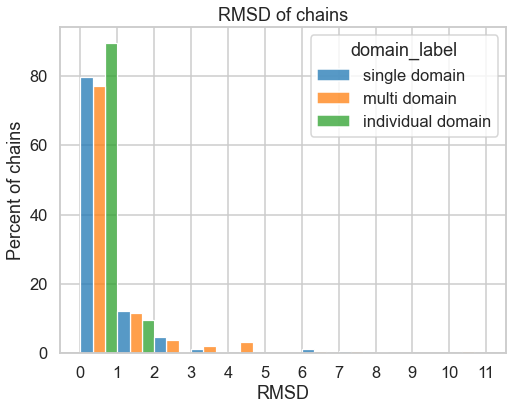

In [51]:
df = analyses_dfs['chain2chain']
df = df[df.analysis_name == 'GetRMSD']

df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'


d2d_rmsd = analyses_dfs['domain2domain'].query('analysis_name == "GetRMSD"')
# for merging, extract in new column only a-h tuple of (pdb_code, chain_id) from the a-h tuple of triples with also a
# domain_id
domain_df = d2d_rmsd[:]
domain_df['apo_holo_chain'] = domain_df.args.apply(lambda domain_pair: (domain_pair[0][0:2], domain_pair[1][0:2]))
domain_df = domain_df.merge(df[df.domain_label == 'multi domain']['args'], left_on='apo_holo_chain', right_on='args')
domain_df['domain_label'] = 'individual domain'

df = pd.concat([df, domain_df], ignore_index=True)

BINWIDTH = 1
ax = sns.histplot(df, x='result', stat='percent', common_norm=False, hue='domain_label', multiple='dodge',
                  bins=rounded_bins(df['result'], BINWIDTH), hue_order=hue_order + ['individual domain'])
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set_title('RMSD of chains')
ax.set_xlabel('RMSD')
ax.set_ylabel('Percent of chains')
save_plot()


H-H RMSD - to zatim nemám

## Domain motions
Two-domain arrangements

filter two-domain arrangements (if of both apo and holo > 200 A^2)

classified movements, 3 classes:
- shear (RMSD > 1 and < 2 Å)
- hinge (RMSD > 2 Å, bending > 10)
- other movement.

>We found that shear-type mechanism is
 the most frequent type of domain motion in the dataset
 (53%); hinge-bending is common for 45%, and the
 remaining cases cannot be unambiguously classified.

2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

In [52]:
# add pair_id column, needed later
def make_pair_id_column(apo_domains, holo_domains):
    apo2DA_unfolded = unfold_tuple_to_columns(apo_domains, ['d1', 'd2'])
    holo2DA_unfolded = unfold_tuple_to_columns(holo_domains, ['d1', 'd2'])

    apo2DA_unfolded = unfold_tuple_to_columns(apo2DA_unfolded['d1'], ['pdb_code', 'chain_id', 'domain_id'])
    holo2DA_unfolded = unfold_tuple_to_columns(holo2DA_unfolded['d1'], ['pdb_code', 'chain_id', 'domain_id'])

    pair_id = tuple_columns(
        tuple_columns(apo2DA_unfolded['pdb_code'], apo2DA_unfolded['chain_id']),
        tuple_columns(holo2DA_unfolded['pdb_code'], holo2DA_unfolded['chain_id']),
    )
    return pair_id

In [53]:
def add_movement_class_col(df, colname='movement'):
    df[colname] = 'N/A'
    df.loc[(df.translation_overall > 1) & (df.hinge_angle < 15), colname] = 'shear'
    df.loc[(df.hinge_angle > 15), colname] = 'hinge'

def add_paper_movement_class_col(df, colname='movement'):
    df[colname] = 'other'
    df.loc[(df.rmsd_2DA <= 1), colname]  = 'N/A'
    df.loc[(df.rmsd_2DA > 1) & (df.rmsd_2DA < 2), colname] = 'shear'
    df.loc[(df.rmsd_2DA > 2) & (df.hinge_angle > 15), colname] = 'hinge'
    return df

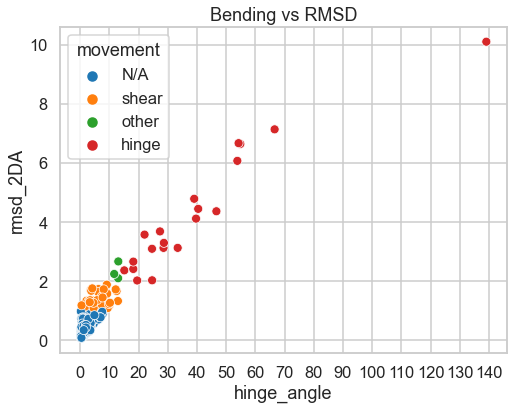

In [54]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_dfs['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']

# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

hinge_df = unfold_tuple_to_columns(hinge_df, ['apo_domains', 'holo_domains'], 'args')
hinge_df['pair_id'] = make_pair_id_column(hinge_df['apo_domains'], hinge_df['holo_domains'])

rmsd_and_hinge = rmsd_df.merge(hinge_df, left_on='args', right_on='args')

df = rmsd_and_hinge
add_paper_movement_class_col(df)
ax = sns.scatterplot(data=df, x='hinge_angle', y='rmsd_2DA', hue='movement')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))
ax.set_title('Bending vs RMSD')
save_plot()

# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají translation_in_axis, třeba
# větší než hinge
# podle částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Mozna, ze ta moje
# druha kategorie bude krásně na diagonále true shear bude od ní. Kdoví. Ale taky se nemusí měnit iface v některých
# konfiguracích, i když dojde k translation



Is shear, as classified in the paper, really a shear motion?
- classified as RMSD value between 1 and 2 (RMSD of apo and holo two-domain arrangements)
- or rather it incorrectly includes cases, where only one domain accommodates the ligand

/var/folders/yd/d0qwckdj493c0xxb37j79t380000gn/T/ipykernel_2698/3171322373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colname] = 'other'
/Users/adam/venvs/apo-holo-protein-structure-stats/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/yd/d0qwckdj493c0xxb37j79t380000gn/T/ipykernel_2698/3171322373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

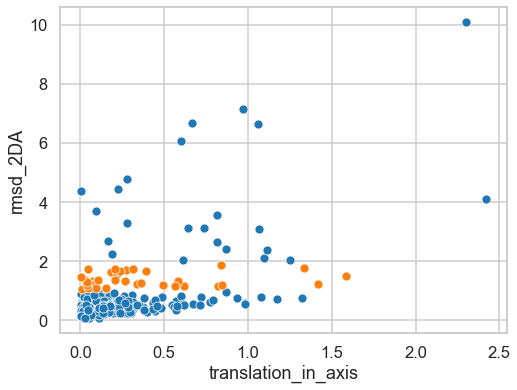

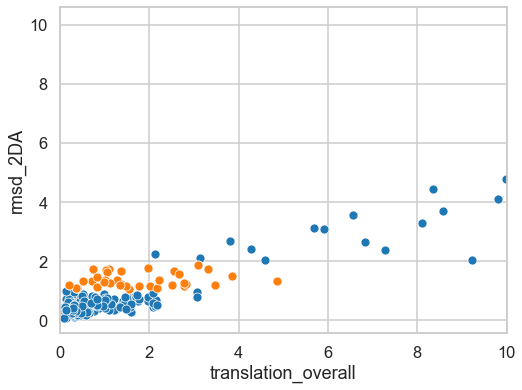

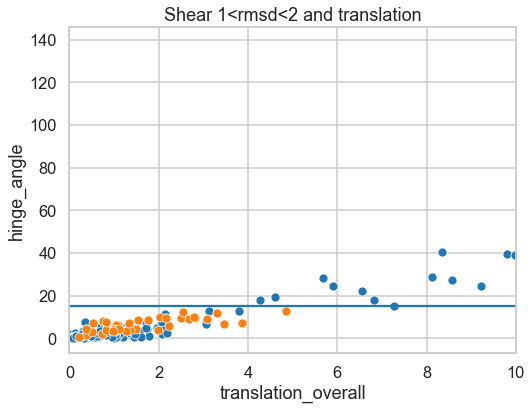

,hinge_angle,translation_overall,translation_in_axis,rmsd_2DA,domain_rmsd_x,domain_rmsd_y
293,0.429783,0.206998,0.041641,1.187808,0.055014,1.307815
256,4.560937,0.359835,0.150416,1.097599,1.309446,0.553011
191,1.511031,0.375502,0.046281,1.090491,0.056740,1.231353
222,2.768808,0.501972,0.267372,1.319734,1.536628,0.412326
77,7.029563,0.519216,0.099588,1.350678,0.928244,1.215255
47,2.121541,0.721315,0.074522,1.340203,1.732553,0.407621
265,8.017631,0.744693,0.313100,1.729216,0.440194,1.616810
48,3.730666,0.815159,0.067924,1.128627,1.852279,0.501434
343,7.644881,0.818032,0.004781,1.452504,0.572430,1.405016
295,3.244375,0.983990,0.040559,1.292534,0.674490,1.517120


In [55]:
df = rmsd_and_hinge[:]
df = unfold_tuple_to_columns(df, ['apo_domains', 'holo_domains'], 'args')
df = unfold_tuple_to_columns(df, ['apo_domain_1', 'apo_domain_2'], 'apo_domains')
df = unfold_tuple_to_columns(df, ['holo_domain_1', 'holo_domain_2'], 'holo_domains')
# convert args, so that format is the same - as single domain rmsd
df['d1_id'] = tuple_columns(df.apo_domain_1, df.holo_domain_1)
df['d2_id'] = tuple_columns(df.apo_domain_2, df.holo_domain_2)
d2d_rmsd_selected_cols = d2d_rmsd[['args', 'result']].rename(columns={'args': 'rmsd_domain_id', 'result': 'domain_rmsd'})
df = df.merge(d2d_rmsd_selected_cols, left_on='d1_id', right_on='rmsd_domain_id')
df = df.merge(d2d_rmsd_selected_cols, left_on='d2_id', right_on='rmsd_domain_id')

all = rmsd_and_hinge[:]
add_paper_movement_class_col(all, 'movement_paper')
add_movement_class_col(all, 'movement')

df = df[(1 < df.rmsd_2DA) & (df.rmsd_2DA < 2)]  # gather shears

# rmsd_2DA vs translation_in_axis
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_in_axis', y='rmsd_2DA')
ax = sns.scatterplot(data=all[all.movement_paper == 'shear'], x='translation_in_axis', y='rmsd_2DA')
plt.show()

# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=df, x='translation_overall', y='rmsd_2DA')
ax.set(xlim=(0, 10))
plt.show()



ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=df, x='translation_overall', y='hinge_angle')
ax.set(xlim=(0, 10))
ax.axhline(15)
ax.set_title('Shear 1<rmsd<2 and translation')
save_plot()
plt.show()


df[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')

# all = all[all.rmsd_2DA > 1]
# all[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')


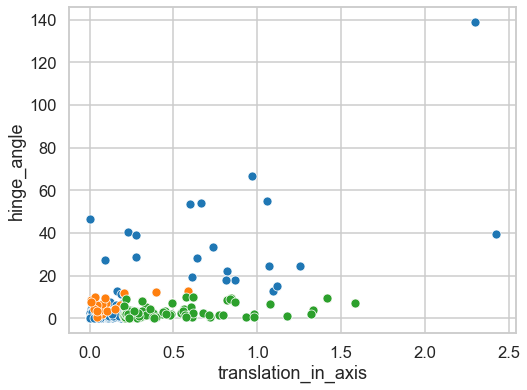

In [56]:
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_in_axis', y='hinge_angle')
ax = sns.scatterplot(data=df, x='translation_in_axis', y='hinge_angle')
ax = sns.scatterplot(data=rmsd_and_hinge[
    (rmsd_and_hinge.translation_in_axis > 0.2) & (rmsd_and_hinge.hinge_angle < 12)], x='translation_in_axis', y='hinge_angle')


2DA ligand-bound vs ligand-free buried interface
- tady vubec potrebuju ty arrangements, ktery treba nemam?
- ty mam bud u 2DA RMSD nebo 2DA angle, je to jedno, oboji vzdy funguje
- join s iface dle paru v jedny str. na apo field a pak druhy na holo

v obou analýzách nejsou a-h-páry, musim to fetchnout pro kazdy z nich
- vlastne pro kazdy 2DA, který nemám expl. nikde, vyuziju tedy RMSD třeba

In [57]:
analyses_dfs['2DA']

,analysis_name,args,kwargs,result,level_tag
0,GetInterfaceBuriedArea,"((2bnu, B, 2bnuB01), (2bnu, B, 2bnuB02), ((2bn...",{},907.519849,2DA
1,GetInterfaceBuriedArea,"((2bnq, E, 2bnuB01), (2bnq, E, 2bnuB02), ((2bn...",{},1008.609877,2DA
2,GetInterfaceBuriedArea,"((1p5h, B, 1p5hB01), (1p5h, B, 1p5hB02), ((1p5...",{},1318.872246,2DA
3,GetInterfaceBuriedArea,"((1p5r, A, 1p5hB01), (1p5r, A, 1p5hB02), ((1p5...",{},1396.443315,2DA
4,GetInterfaceBuriedArea,"((3ng1, B, 3ng1B01), (3ng1, B, 3ng1B02), ((3ng...",{},1518.288037,2DA
...,...,...,...,...,...
675,GetInterfaceBuriedArea,"((1rzm, A, 1vr6A01), (1rzm, A, 1vr6A02), ((1vr...",{},1324.798241,2DA
676,GetInterfaceBuriedArea,"((1inl, C, 1inlC01), (1inl, C, 1inlC02), ((1in...",{},2164.066031,2DA
677,GetInterfaceBuriedArea,"((1jq3, C, 1inlC01), (1jq3, C, 1inlC02), ((1in...",{},2168.551765,2DA
678,GetInterfaceBuriedArea,"((1xo6, C, 1xo6C01), (1xo6, C, 1xo6C02), ((1xo...",{},2360.673164,2DA


/Users/adam/venvs/apo-holo-protein-structure-stats/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'level_tag_x', 'kwargs_x', 'analysis_name_x', 'args_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


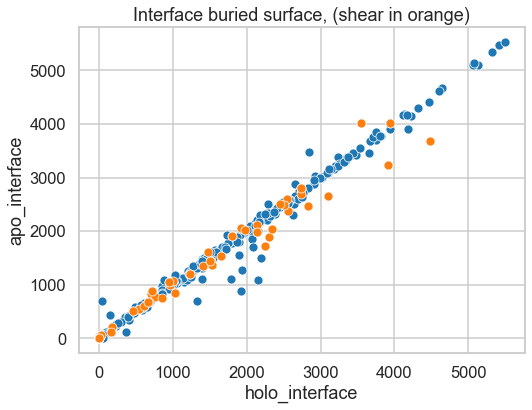

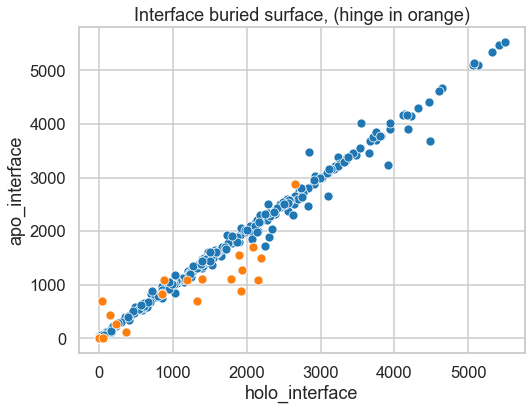

In [58]:
df = analyses_dfs['chain2DA2chain2DA']
two_domain_arrangements = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
two_domain_arrangements = unfold_tuple_to_columns(two_domain_arrangements, ['apo_domains', 'holo_domains'], 'args')
two_domain_arrangements['pair_id'] = make_pair_id_column(two_domain_arrangements['apo_domains'], two_domain_arrangements['holo_domains'])


# df = analyses_dfs['2DA']
# interface_area = df[df.analysis_name == 'GetInterfaceBuriedArea']
#
# df = two_domain_arrangements.merge(interface_area, left_on='apo_domains', right_on='args')
# df = df.rename(columns={'result': 'apo_interface'})
# df = df.merge(interface_area, left_on='holo_domains', right_on='args')
# df = df.rename(columns={'result': 'holo_interface'})
#
# interface_area_apo_holo = df
#
# print(len(df))
# df2 = unfold_tuple_to_columns(hinge_df, ['apo_domains', 'holo_domains'], 'args')
# df = df.merge(df2, left_on='apo_domains', right_on='apo_domains')
# print(len(df))
#
# add_paper_movement_class_col(df)
#
# ax = sns.scatterplot(data=df, x='holo_interface', y='apo_interface', hue='movement', alpha=0.8)
# ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))
# ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))
#
# # ax = sns.scatterplot(data=df[(df.translation_in_axis > 0.2) & (df.hinge_angle < 12)], x='holo_interface', y='apo_interface')
# ax.set_title('Interface buried surface')
# save_plot()

analyses_by_level = analyses_dfs
df = analyses_by_level['2DA']

interface_area = df[df.analysis_name == 'GetInterfaceBuriedArea']
df = unfold_tuple_to_columns(interface_area, ['d1', 'd2', 'pair_id'], 'args')
interface_area['2DA_id'] = tuple_columns(df.d1, df.d2)
interface_area['pair_id'] = df['pair_id']
interface_area = interface_area.set_index(['2DA_id', 'pair_id'])

df = two_domain_arrangements.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_index=True)
df = df.rename(columns={'result': 'apo_interface'})
df = df.merge(interface_area, left_on=['holo_domains', 'pair_id'], right_index=True)
df = df.rename(columns={'result': 'holo_interface'})

interface_area_apo_holo = df

rmsd_and_hinge_and_interface = rmsd_and_hinge.merge(
    # choose only the result columns
    interface_area_apo_holo[['apo_domains', 'holo_domains', 'pair_id', 'apo_interface', 'holo_interface']],
    on=['apo_domains', 'holo_domains', 'pair_id'])

# check df length for duplicates
# duplicated, as two chains have two UNP ids (and the dupes even increased during the merges)
rmsd_and_hinge_and_interface = rmsd_and_hinge_and_interface.drop_duplicates(['apo_domains', 'holo_domains'])


def show_all():
    ax = sns.scatterplot(data=df, x='holo_interface', y='apo_interface')
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))

df = df.merge(hinge_df, left_on=['apo_domains', 'pair_id'], right_on=['apo_domains', 'pair_id'])

def show_shear():
    sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 15)], x='holo_interface', y='apo_interface')

def show_hinge():
    sns.scatterplot(data=df[(df.hinge_angle > 15)], x='holo_interface', y='apo_interface')

show_all()
show_shear()
plt.title('Interface buried surface, (shear in orange)')
save_plot()
plt.show()


show_all()
show_hinge()
plt.title('Interface buried surface, (hinge in orange)')
save_plot()
plt.show()

# todo udělat diagonálu

# df[df.apo_interface > 6000]
# 8300 outlier = large beta barrel 1pnz, 1kmo


Compared to the paper, it's estimated as larger.

2DA
prediktor large-scale motion type z apo interface buried

interface buried (apo) vs (bending)|(RMSD - opět 2DA-explicitně)
- scatter and histogram


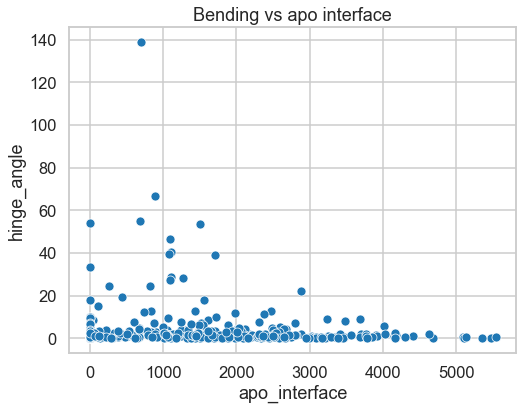

In [59]:
df = hinge_df
df = df.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result_y': 'apo_interface'})

# print(len(df))
# df = df.merge(rmsd_df, on='args')
# add_paper_movement_class_col(df)
# print(len(df))


ax = sns.scatterplot(data=df, x='apo_interface', y='hinge_angle')#, hue='movement')
ax.set_title('Bending vs apo interface')
save_plot()

# true shear dataset
# sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 12)], x='apo_interface', y='hinge_angle')

    We can see that domain interface area (in apo structure) indeed sets a limit on whether the domains can do a hinge motion. Hinge bending domain pairs with interface area larger than 2000 Å^2 were not observed.

The conclusion for shear, in the paper, holds too.
No lg scale dom. movements above 3550 A2 interface.

deducible by the
examination of a ligand-free structural form alone.
- mění se něco? Může to být víc deducible ještě z něčeho novýho, co máme ted k dispozici? Asi ne..

342
346
Index(['analysis_name_x', 'args', 'kwargs_x', 'rmsd_2DA', 'level_tag_x',
       'analysis_name_y', 'kwargs_y', 'result', 'level_tag_y', 'hinge_angle',
       'translation_in_axis', 'translation_overall', 'apo_domains',
       'holo_domains', 'pair_id', 'movement'],
      dtype='object')
Index(['analysis_name_x', 'args_x', 'kwargs_x', 'rmsd_2DA', 'level_tag_x',
       'apo_domains', 'holo_domains', 'pair_id', 'analysis_name_y', 'args_y',
       'kwargs_y', 'apo_interface', 'level_tag_y', 'analysis_name', 'args',
       'kwargs', 'holo_interface', 'level_tag'],
      dtype='object')
370


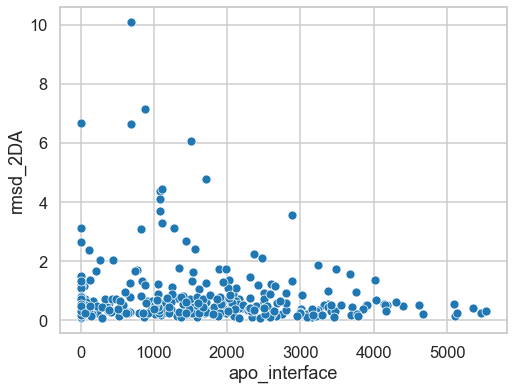

In [60]:
# df = unfold_tuple_to_columns(rmsd_df, ['apo_domains', 'holo_domains'], 'args')
# df = df.merge(interface_area.rename(columns={'result': 'apo_interface'}).set_index('args'), left_on='apo_domains', right_index=True)
#
# print(len(df))
# df = df.merge(hinge_df, on='args')
# add_paper_movement_class_col(df)
# print(len(df))
#
# ax =sns.scatterplot(data=df, x='apo_interface', y='rmsd_2DA', hue='movement')
# ax.set_title('RMSD vs apo interface')
# save_plot()
#

# df = rmsd_df
# print(len(df))
# df = df.merge(hinge_df, on='args')
# print(len(df))  # todo najednou o dva pary vic, to je nejaky spatny..
# # nejlepsi bude udelat na zacatku jeden velkej df (tzv long-form), abych to nemergoval furt pred kazdym grafem a taky
# # je mohl jednoduše přidávat a bylo ot přehledně na jednom místě - a pak to rovnou můžu upravit, až budu používat serializaci ne do těch k ničemu tuplu, ale dictu, ktery se pak serializujou třeba na 'dict.key' 'dict.key2', pak sice nefu
# # guje dot-access, tak vubec nevim, proc to takhle navrhli, ale aspon se to bude nějak jmenovat a nebudu muset pokazdy
# # vytvaret columny)
# # pak samozřejmě tam může být míň těch párů v těch grafem, pokud některý analýzy neprošly (chyba), ale myslim, že tady se to zrovna neděje - rmsd (mozna pada, ale z toho to beru, spis uz nepada..), hinge - nepada, interface area - nepada
#
# # df = unfold_tuple_to_columns(df, ['apo_domains', 'holo_domains'], 'args')
# df['pair_id'] = make_pair_id_column(df['apo_domains'], df['holo_domains'])
#
#
#
# print(len(df))
# #
# # df = df.merge(hinge_df, on='args')
# print(len(df))


print(len(rmsd_and_hinge))
print(len(interface_area_apo_holo))  # klidně muze byt vickrat jedna 2DA - chain muze byt teoreticky vickrat nekde?
print(rmsd_and_hinge.columns)
print(interface_area_apo_holo.columns)
df = rmsd_and_hinge.merge(
    # choose only the result columns
    interface_area_apo_holo[['apo_domains', 'pair_id', 'apo_interface', 'holo_interface']],
    on=['apo_domains', 'pair_id'])
print(len(df))

sns.scatterplot(data=df, x='apo_interface', y='rmsd_2DA')
ax.set_title('RMSD vs apo interface')
save_plot()


table with selected 2DA


dataframe vlastne mam, staci pouzit iloc



extract the pair codes and do a similar table (choosing from 2DA file, should be easy)
potřebuju span do domain serializace ideálně
|apo_code|holo_code|2 domains id|a-interface| h-interface|bending[deg]| RMSD


In [61]:
# table_chains = '../../manual_test_data/paper_pdf_results_table_chains'
table_chains = '../manual_test_data/paper_pdf_results_table_chains'
# načist do df, mergovat s tim nahoře, a je to
paper_table_df = pd.read_csv(table_chains, delimiter=r' ', header=None, names=('apo_chain', 'holo_chain'))
paper_table_df['apo_holo_struct'] = list(zip(
    paper_table_df.apo_chain.apply(lambda s: s[:4]),
    paper_table_df.holo_chain.apply(lambda s: s[:4]),
))

analyses_df = rmsd_and_hinge_and_interface
# analyses_df = analyses_df.merge(hinge_df.rename(columns={'args': 'args_hinge'})[['args_hinge', 'hinge_angle']],
#                                 left_on='args_x', right_on='args_hinge')

analyses_df['apo_holo_struct'] = analyses_df.args.apply(lambda domain_pair: (domain_pair[0][0][0],
                                                                             domain_pair[1][0][0]))

df = paper_table_df.merge(analyses_df, left_on='apo_holo_struct', right_on='apo_holo_struct')
# v paperu jen D1, D2, počítám, že to je apo numbering (a taky to je numbering auth_seq_id, nikoliv label seq id
df = unfold_tuple_to_columns(df, ['apo_domain_1', 'apo_domain_2'], 'apo_domains')
# merge in metadata of both domains
df = df.merge(analyzed_domains[['full_id', 'spans_auth_seq_id', 'pair_id']], left_on=['apo_domain_1', 'pair_id'], right_on=['full_id', 'pair_id'])
df = df.merge(analyzed_domains[['full_id', 'spans_auth_seq_id', 'pair_id']], left_on=['apo_domain_2', 'pair_id'], right_on=['full_id', 'pair_id'])


df = df.set_index(['apo_chain', 'holo_chain', 'apo_domains', 'holo_domains'])[['apo_interface', 'holo_interface',
                                                                               'rmsd_2DA', 'spans_auth_seq_id_x', 'spans_auth_seq_id_y']]

df = df[(df.apo_interface > 100) & (df.holo_interface > 100)]
#, 'hinge_angle']]

# pd.MultiIndex from apo_holo_chain_x and domain
df.style.format(precision=0, formatter={'rmsd_2DA': '{:.1f}'})


In [62]:
print(len(rmsd_df))
print(len(rmsd_and_hinge))
print(len(rmsd_and_hinge_and_interface))
print(len(interface_area_apo_holo))

print(rmsd_df[rmsd_df.duplicated(['args'])])
print(len(hinge_df.drop_duplicates(['args'])))
print(len(rmsd_and_hinge_and_interface.drop_duplicates(['apo_domains', 'holo_domains'])))

340
342
339
346
   analysis_name                                               args kwargs  \
89       GetRMSD  (((2bnu, B, 2bnuB01), (2bnu, B, 2bnuB02)), ((2...     {}   

    rmsd_2DA          level_tag  
89  0.657788  chain2DA2chain2DA  
339
339
